In [1]:
import pandas as pd
import numpy as np
import pyodbc

# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline # needed in order to include SMOTE preprocessing step(won't work with regular pipeline)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
#from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
connection = pyodbc.connect('DSN=TDPRD1')

sql = """select
    A.ord_fr_supl_id as supl_id,
	A.purch_doc_nbr,
    A.purch_doc_line_nbr,
    A.purch_org_cd, 
    A.supl_mtrl_nbr, 
    --A.purch_doc_line_shrt_dsc,
    A.purch_line_net_usd_amt, 
    A.mtrl_grp_cd,
    A.plnt_nm, 
    A.plnt_id,
    A.strg_loc_id,
    A.mtrl_id,
	--A.intrnl_po_note_txt,
	A.purch_doc_cre_uid,
	A.purch_grp_cd,
	A.supplier_tender_date,
	A.stats_dlvr_dt,
	A.dlvr_dt,
	CASE WHEN A.purch_line_rcv_sts_cd IN ('OPEN','PARTIAL') THEN NULL ELSE A.purch_line_last_rcpt_dt - A.dlvr_dt END as DaysLate,
	purch_line_last_rcpt_dt,
	A.purch_line_rcv_sts_cd,
    B.itm_dsc,
	A.shp_cond_cd,
	Cast(A.purch_line_cre_ts as Date) POCreate,
	A.stats_dlvr_dt - Cast(A.purch_line_frst_authr_ts as Date) as LeadTime,
	Cast(A.purch_line_frst_authr_ts as Date) as purch_line_frst_authr_dt,
	to_char(A.dlvr_dt, 'Month') as MonthDue,
	'Week '||to_char(A.dlvr_dt, 'iw') as WeekDue,
	A.tchls_ind,
	CASE WHEN e.EventCnt > 0 THEN e.EventCnt ELSE 0 End as EventCnt,
	A.cfm_ctrl_cd,
	CASE WHEN C.ChangeCnt > 0 THEN C.ChangeCnt ELSE 0 END as ChangeCnt,
    A.purch_doc_line_qty,
    A.purch_line_aprv_tpt_day_cnt,
    case when coalesce(A.purch_doc_dlvr_chg_dt, to_date('2099-12-31')) = '2099-12-31' then 'N' else 'Y' end as dlvr_chg_ind,
    to_char(A.purch_line_cre_dt, 'iw') POCreateWW,
    A.high_lvl_src_org_cd,
    A.frst_seq_gl_acct_char_nbr,
	PH.inco_term_cd,
	PH.inco_term_dsc_2 as inco_term_dsc,
	CASE WHEN Carrier.Carrier IS NULL THEN 'UNKNOWN' ELSE Carrier.Carrier END as Carrier,
    F.lead_tm_day_cnt,
    --CASE WHEN F.inv_mgmt_grp_nm IS NULL THEN 'UNKNOWN' ELSE F.inv_mgmt_grp_nm END as inv_mgmt_grp_nm
	--CASE WHEN F.rplnsh_mthd_nm IS NULL THEN 'UNKNOWN' ELSE F.rplnsh_mthd_nm END as rplnsh_mthd_nm,
	--CASE WHEN F.rpr_type_nm IS NULL THEN 'UNKNOWN' ELSE F.rpr_type_nm END as rpr_type_nm,
	--CASE WHEN F.crtcl_itm_ind IS NULL THEN 'UNKNOWN' ELSE F.crtcl_itm_ind END as crtcl_itm_ind,
	--CASE WHEN F.cnsgn_ind IS NULL THEN 'UNKNOWN' ELSE F.cnsgn_ind END as cnsgn_ind
	PA.ctry_cd as ship_to_ctry_cd,
    S.ctry_cd as supl_ctry_cd,
    CASE WHEN PA.ctry_cd = S.ctry_cd THEN 'DOMESTIC' ELSE 'INTERNATIONAL' END as ShipmentType
    
from Procurement_Analysis.v_fact_purch_ord_line A
left join Procurement_Analysis.v_dim_itm B
on B.itm_id=A.mtrl_id

left join Factory_Materials_Analysis.v_dim_fctry_item_strg_loc F
on A.mtrl_id = F.itm_id and A.strg_loc_id = F.strg_loc_cd --and A.ord_fr_supl_id = F.curr_supl_id


left join (
	select
	sr.shp_ref_nbr,
	count(e.evnt_cd) as EventCnt,
	min(CAST(utc_bol_evnt_dt AS TIMESTAMP(0)) + (utc_bol_evnt_tm - TIME '00:00:00' HOUR TO SECOND)) as MinEventDate

	from shipment.v_bol_ref_TRK sr
	left join shipment.v_bol_hdr_TRK sh
	on sr.bol_id=sh.bol_id
	left join  shipment.v_bol_evnt_TRK e
	on e.bol_id = sh.bol_id
	where e.evnt_cd in ('HIC','ADQ','CAN')
	and sr.shp_ref_nbr like '7%'
	and length(sr.shp_ref_nbr)=10
	group by sr.shp_ref_nbr
) e
on e.shp_ref_nbr = A.purch_doc_nbr

left join (
	select
	C.purch_doc_nbr PONbr,
	C.purch_doc_line_nbr POLineNbr,
	count(*) ChangeCnt
	from Procurement_Analysis.v_fact_pr_po_chg_mntr C
	 left outer Join   (
	 select *
	 from Procurement_Analysis.v_lkup_pr_po_chg_type
	 where  rpt_type_cd IN ('PO')) T
	ON (C.chg_nm_id=T.chg_nm_id)
	JOIN (
	SELECT * FROM Procurement_Analysis.v_fact_purch_ord_line
	   where  purch_line_frst_authr_dt >= trunc(add_months(current_date,-24), 'MM') AND Extract (YEAR From purch_line_frst_authr_dt) NOT IN (9999)) PO
	ON (PO.purch_doc_nbr = C.purch_doc_nbr and PO.purch_doc_line_nbr = C.purch_doc_line_nbr
	--and C.usr_nm NOT IN ('XI_CAPITAL','WF-BATCH','WF_BATCH','XI_BPMS')
	)
	where C.rpt_type_cd in ('PO') and C.purch_doc_line_nbr<>'*'
	group by C.purch_doc_nbr,C.purch_doc_line_nbr
) C
on (A.purch_doc_nbr = C.PONbr and A.purch_doc_line_nbr = C.POLineNbr)

left join Procurement_Analysis.v_dim_supl_geo as S
on (S.supl_id = A.ord_fr_supl_id)

left join Procurement_Analysis.v_fact_purch_ord_hdr as PH
on (A.purch_doc_nbr = PH.purch_doc_nbr)

--------------------------------- Join Carrier Query------------------
left join
(
select s.shp_ref_nbr,TRIM(TRAILING ',' FROM (XMLAGG(trim(s.carr_cd) || ','
        ORDER BY s.carr_cd desc
   ) (VARCHAR(500)))) Carrier
from (
select distinct sr.shp_ref_nbr,sh.carr_cd
from shipment.v_bol_ref_TRK sr
left join shipment.v_bol_hdr_TRK sh
on sr.bol_id=sh.bol_id
left join  shipment.v_bol_evnt_TRK e
on e.bol_id = sh.bol_id
where sr.shp_ref_nbr in
(
select distinct A.purch_doc_nbr
from Procurement_Analysis.v_fact_purch_ord_line A
where A.purch_line_frst_authr_dt >= trunc(add_months(current_date,-24), 'MM') AND Extract (YEAR From A.purch_line_frst_authr_dt) NOT IN (9999)
and A.purch_doc_nbr like '7%'
and A.strg_loc_id In ('24','26','33','107','167','189','193','194','188','210')
and A.purch_doc_line_del_ind not in ('Y')
and A.purch_line_rcv_sts_cd not in ('NON RECEIV')
)
) s
group by s.shp_ref_nbr
) Carrier
on (Carrier.shp_ref_nbr = A.purch_doc_nbr)
---------------------End Carrier Query----------------------

left join Procurement_Analysis.v_po_manl_addr as PA
on (A.purch_doc_nbr = PA.purch_ord_nbr and A.purch_doc_line_nbr = PA.purch_ord_line_nbr)

where A.purch_line_frst_authr_dt >= trunc(add_months(current_date,-24), 'MM') AND Extract (YEAR From A.purch_line_frst_authr_dt) NOT IN (9999)
and A.purch_doc_nbr like '7%'
and A.strg_loc_id In ('24','26','33','107','167','189','193','194','188','210')
and A.purch_doc_line_del_ind not in ('Y')
and A.purch_line_rcv_sts_cd not in ('NON RECEIV')
"""
data = pd.read_sql(sql,connection)

connection.close()

In [3]:
# Add POHeaderNotes data to model

#df_POHeaderNotes = pd.read_csv(r'C:\Users\jrstrong\Desktop\temp\POHeaderNotes.csv', encoding = "ISO-8859-1")

#df_POHeaderNotes['txt_doc_id'] = df_POHeaderNotes.txt_doc_id.astype(str)
#df_POHeaderNotes['txt_doc_id'] = df_POHeaderNotes['txt_doc_id'].str.strip()

#data = pd.merge(data,
#                df_POHeaderNotes,
#                left_on=['purch_doc_nbr'],
#                right_on=['txt_doc_id'],how='left')

In [4]:
# identify numeric vs categorical features

data['IsLate'] = np.where(data['DaysLate'] > 0, 'Late', 'OnTime')
df_training = data[(data.DaysLate.notnull()) & (data.purch_line_rcv_sts_cd.str.strip() == 'COMPLETE')]

selectedFeatures = ['supl_id','purch_org_cd','supl_mtrl_nbr','strg_loc_id','mtrl_id','purch_doc_cre_uid','purch_grp_cd',
                    'purch_line_net_usd_amt',
                    'WeekDue','EventCnt','cfm_ctrl_cd','ChangeCnt','purch_doc_line_qty',
                    #'txt',
                    'purch_line_aprv_tpt_day_cnt','dlvr_chg_ind','POCreateWW','high_lvl_src_org_cd',
                    'tchls_ind',
                    'frst_seq_gl_acct_char_nbr','supl_ctry_cd','ship_to_ctry_cd','inco_term_cd','inco_term_dsc','Carrier',
                    'lead_tm_day_cnt','ShipmentType',
                    #'rplnsh_plcy_nm','rplnsh_mthd_nm','rpr_type_nm','crtcl_itm_ind','cnsgn_ind',
                    'IsLate']

df_training = df_training[selectedFeatures]

numeric_features = df_training.select_dtypes(include=np.number).columns#.tolist()

categorical_features = df_training.select_dtypes(include=['object']).drop(['IsLate'
                                                                           #,'txt'
                                                                          ], axis=1).columns

X = df_training.drop(['IsLate'], axis=1)
y = df_training[['IsLate']]

In [5]:
# Data cleanup for POHeaderNotes text

#df_training.txt.fillna(value='', inplace=True)

#import re
#import nltk

#def remove_numbers(wordtoken):
#    return re.sub(r'\d',r'_',wordtoken)

#def tokenize_string(strng):
#    return nltk.word_tokenize(strng)

#punct= list('"\'()*`{|}~/')
#def remove_punct(wordtokens):
#    return [wordtoken for wordtoken in wordtokens if wordtoken not in punct]

#df_training['txt'] = df_training.txt.str.lower()
#df_training['txt'] = df_training.txt.apply(remove_numbers)
#df_training['txt'] = df_training.txt.apply(tokenize_string)

#stopwords= set(nltk.corpus.stopwords.words('english'))
#def remove_stopwords(wordtokens):
#    return [wordtoken for wordtoken in wordtokens if wordtoken not in stopwords]

# Porter Stem Tokens
#from nltk.stem.porter import PorterStemmer
#ps = PorterStemmer()
#def stem_tokens(wordtokens):
#    return [ps.stem(word) for word in wordtokens]

#df_training['txt'] = df_training.txt.apply(remove_stopwords)
#df_training['txt'] = df_training.txt.apply(remove_punct)
#df_training['txt'] = df_training.txt.apply(stem_tokens)

#display dataframe rows with value in the txt field
#df_training[df_training['txt'].map(lambda d: len(d)) > 0]

In [6]:
# Preprocessing steps for numerical and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=None,strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

# Preprocessing step for text data
#def dummy(doc):
#    return doc
#text_transformer = Pipeline(steps=[
#    ('TfidfVectorizer', TfidfVectorizer(tokenizer=dummy,preprocessor=dummy))])

In [7]:
# use the ColumnTransformer to apply the transformations to the correct columns in the dataframe

from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
        #,('txt', text_transformer, 'txt')
    ])

In [8]:
#df_training.txt.fillna(value='', inplace=True)
X = df_training.drop(['IsLate'], axis=1)
y = df_training[['IsLate']]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [9]:
#from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

lr_pipeline= Pipeline([
    ('preprocessor', preprocessor),
    ('randomsampler', RandomOverSampler()),
    ('LogisticRegression', LogisticRegressionCV(n_jobs=-1,
                                              verbose=2,
                                              class_weight='balanced'
                                             ))
])

lr_pipeline.fit(X_train, y_train.values.ravel())
lr_predictions= lr_pipeline.predict(X_test)

print(classification_report(y_test, lr_predictions))
print(confusion_matrix(y_test, lr_predictions))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   59.2s remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   59.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   59.8s finished
C:\Users\jrstrong\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

        Late       0.39      0.68      0.50      9176
      OnTime       0.92      0.79      0.85     44524

    accuracy                           0.77     53700
   macro avg       0.66      0.73      0.67     53700
weighted avg       0.83      0.77      0.79     53700

[[ 6207  2969]
 [ 9514 35010]]


In [30]:
import lightgbm as lgb

lgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('upsampler', SMOTE()),
    ('LGBMClassifier', lgb.LGBMClassifier(verbosity=2,n_jobs=-1))   
])

lgb_pipeline.fit(X_train, y_train.values.ravel())
lgb_predictions = lgb_pipeline.predict(X_test)

print(classification_report(y_test, lgb_predictions))
print(confusion_matrix(y_test, lgb_predictions))

              precision    recall  f1-score   support

        Late       0.57      0.43      0.49      9073
      OnTime       0.89      0.93      0.91     44627

    accuracy                           0.85     53700
   macro avg       0.73      0.68      0.70     53700
weighted avg       0.84      0.85      0.84     53700

[[ 3944  5129]
 [ 2935 41692]]


In [20]:
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('randomsampler', RandomOverSampler()),
    ('RandomForestClassifier', RandomForestClassifier(#class_weight='balanced',
                                                      verbose=2,
                                                      n_estimators=8,
                                                      n_jobs=-1))
])

rf_pipeline.fit(X_train, y_train.values.ravel())
rf_predictions= rf_pipeline.predict(X_test)

print(classification_report(y_test, rf_predictions))
print(confusion_matrix(y_test, rf_predictions))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 8
building tree 2 of 8
building tree 3 of 8
building tree 4 of 8
building tree 5 of 8
building tree 6 of 8
building tree 7 of 8building tree 8 of 8



[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:   42.4s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   43.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   43.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


              precision    recall  f1-score   support

        Late       0.61      0.63      0.62      9176
      OnTime       0.92      0.92      0.92     44524

    accuracy                           0.87     53700
   macro avg       0.77      0.77      0.77     53700
weighted avg       0.87      0.87      0.87     53700

[[ 5740  3436]
 [ 3626 40898]]


In [14]:
from sklearn.neighbors import KNeighborsClassifier

k_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('randomsampler', RandomOverSampler()),
    ('KNeighborsClassifier', KNeighborsClassifier(#n_neighbors=14,
                                                  #p=2,
                                                  weights='distance',
                                                  n_jobs=-1))
])

k_pipeline.fit(X_train, y_train.values.ravel())
k_predictions= k_pipeline.predict(X_test)

print(classification_report(y_test, k_predictions))
print(confusion_matrix(y_test, k_predictions))

              precision    recall  f1-score   support

        Late       0.48      0.74      0.59      9176
      OnTime       0.94      0.84      0.89     44524

    accuracy                           0.82     53700
   macro avg       0.71      0.79      0.74     53700
weighted avg       0.86      0.82      0.83     53700

[[ 6833  2343]
 [ 7302 37222]]


In [ ]:
import tpot

tpot_config = {
    'sklearn.ensemble.RandomForestClassifier': {
        'class_weight':['balanced']
        ,'n_estimators':[8]
    },
}

tpot_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('randomsampler', RandomOverSampler()),
    ('TPOTClassifier', tpot.TPOTClassifier(#config_dict='TPOT sparse',
                                           scoring='f1_weighted',
                                           n_jobs=-1,
                                           verbosity=2,
                                           generations=10, # 100 is default
                                           population_size=10, # 100 is default
                                           config_dict=tpot_config
                                          ))
])
    
tpot_pipeline.fit(X_train, y_train.values.ravel())
tpot_predictions= tpot_pipeline.predict(X_test)

print(classification_report(y_test, tpot_predictions))
print(confusion_matrix(y_test, tpot_predictions))

C:\Users\jrstrong\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\jrstrong\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [9]:
df_training.to_csv(r'C:\Users\jrstrong\Desktop\temp\atidmoverdue.csv', index=False)

In [128]:
# Use this to determine strength of correlations between numeric features and the dependent variable.

corr = df_training[numeric_features.tolist()+['IsLate']]
corr['IsLate']=(corr['IsLate']=='Late').astype(int)

correl = corr.corr()

correl.style.background_gradient(cmap='coolwarm')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,purch_line_net_usd_amt,EventCnt,ChangeCnt,purch_doc_line_qty,purch_line_aprv_tpt_day_cnt,lead_tm_day_cnt,IsLate
purch_line_net_usd_amt,1,-0.00102635,0.0486301,0.202918,0.00868779,-0.0490062,0.0879232
EventCnt,-0.00102635,1,0.0174966,0.000223573,0.0428413,-0.065874,0.045138
ChangeCnt,0.0486301,0.0174966,1,-0.0143082,0.0782421,-0.00556465,0.0902024
purch_doc_line_qty,0.202918,0.000223573,-0.0143082,1,-0.00183122,-0.0742912,0.0302575
purch_line_aprv_tpt_day_cnt,0.00868779,0.0428413,0.0782421,-0.00183122,1,0.0011082,0.0301555
lead_tm_day_cnt,-0.0490062,-0.065874,-0.00556465,-0.0742912,0.0011082,1,-0.110765
IsLate,0.0879232,0.045138,0.0902024,0.0302575,0.0301555,-0.110765,1


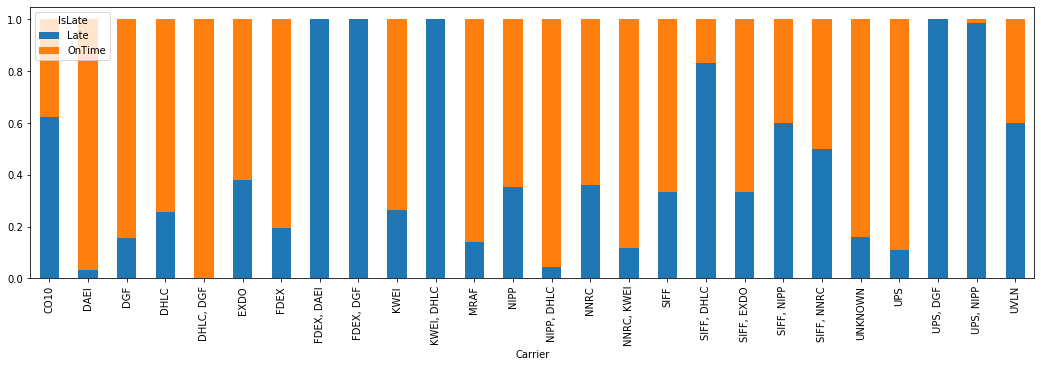

In [127]:
# Use this to compare each feature against the dependent variable, IsLate to visually determine its importance. It shows the proportion of Late to OnTime orders.

props = df_training.groupby("Carrier")['IsLate'].value_counts(normalize=True).unstack()
props.plot(kind='bar', stacked='True', figsize=(18,5))

In [18]:
df_predictions = data[(data.DaysLate.isnull()) & (data.purch_line_rcv_sts_cd.str.strip() != 'COMPLETE')]

df_predictions['Prediction'] = rf_pipeline.predict(df_predictions[selectedFeatures])
df_predictions['Probability'] = np.amax(rf_pipeline.predict_proba(df_predictions[selectedFeatures]),1)

C:\Users\jrstrong\AppData\Roaming\Python\Python37\site-packages\sklearn\compose\_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\jrstrong\AppData\Roaming\Python\Python37\site-packages\sklearn\compose\_column_transfo

In [85]:
df_predictions[['purch_doc_nbr','purch_doc_line_nbr','Prediction','Probability']].to_csv(r'C:\Users\jrstrong\Desktop\temp\AT_IDM_OTDPredictions.csv', index=False)

In [81]:
df_predictions[(df_predictions['Prediction']=='Late') & (df_predictions.purch_line_rcv_sts_cd.str.strip().isin(['OPEN','PARTIAL']))]

,supl_id,purch_doc_nbr,purch_doc_line_nbr,purch_org_cd,supl_mtrl_nbr,purch_line_net_usd_amt,mtrl_grp_cd,plnt_nm,plnt_id,strg_loc_id,...,high_lvl_src_org_cd,frst_seq_gl_acct_char_nbr,supl_ctry_nm,inco_term_cd,inco_term_dsc,Carrier,lead_tm_day_cnt,IsLate,Prediction,Probability
143,1000003489,7001688057,00010,1149,168007304,26572.00,95990051,Saigon HTP-Campus CC,SS,167,...,S064,503480,United States,EXW,Buyer pays from seller dock,UNKNOWN,21.0,OnTime,Late,0.666667
196,1000006430,7001671592,00050,1005,98021234657,70795.12,95990051,Kulim-Campus CC750,KMA,24,...,S064,504220,Malaysia,DAP,Seller pays frt not duty Place,UNKNOWN,65.0,OnTime,Late,0.750000
264,1000012719,7001678009,00010,1127,DBTG0007,2100.00,95990051,Chandler-Campus CC10,CH,26,...,S064,504220,United States,EXW,Buyer pays from seller dock,UNKNOWN,30.0,OnTime,Late,1.000000
266,1000003432,7001698544,00010,1149,H19-1340-2148,15326.99,95990070,Saigon HTP-Campus CC,SS,167,...,S005,503420,United States,FCA,Buyer pays from export port,UNKNOWN,35.0,OnTime,Late,0.500000
306,1000014855,7001713650,00020,1149,92000250129,0.00,95990051,Saigon HTP-Campus CC,SS,167,...,S064,504240,Singapore,FCA,Buyer pays from export port,UNKNOWN,65.0,OnTime,Late,0.583333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186192,1000092631,7001687165,00020,1008,19650901,2860.00,95990070,Hi-Tech West Park-Ca,CD,107,...,S005,503420,China,DDP,"Seller pays frt, customs+duty",UNKNOWN,25.0,OnTime,Late,0.666667
186304,1000005781,7001697504,00010,1008,11BDN0167,6075.00,95990065,Hi-Tech West Park-Ca,CD,107,...,S005,503420,Singapore,EXW,Buyer pays from seller dock,UNKNOWN,20.0,OnTime,Late,0.666667
186513,1000062502,7001716637,00010,1149,01-E56721,3800.00,95990051,Saigon HTP-Campus CC,SS,167,...,S064,503480,Singapore,FCA,Buyer pays from export port,UNKNOWN,30.0,OnTime,Late,0.666667
186612,1000025332,7001711756,00010,1005,13158-114,2704.94,95990331,Bayan Lepas-Campus C,PG,33,...,S005,503340,Malaysia,DAP,Seller pays frt not duty Place,UNKNOWN,45.0,OnTime,Late,0.666667


In [69]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
df_encoded = df_training[categorical_features].apply(LabelEncoder().fit_transform)
y_encoded = df_training[['IsLate']].apply(LabelEncoder().fit_transform)

si = SimpleImputer(strategy='median')
mm = MinMaxScaler()
df_scaled = pd.DataFrame(si.fit_transform(df_training[numeric_features]),columns = numeric_features)
df_scaled = pd.DataFrame(mm.fit_transform(df_scaled),columns = numeric_features)

df_encoded.reset_index(drop=True, inplace=True)
df_scaled.reset_index(drop=True, inplace=True)

# Place the DataFrames side by side
df_feature_selection = pd.concat([df_encoded,df_scaled], axis = 1)

In [70]:
df_feature_selection.columns

Index(['supl_id', 'purch_org_cd', 'supl_mtrl_nbr', 'strg_loc_id', 'mtrl_id',
       'purch_doc_cre_uid', 'purch_grp_cd', 'WeekDue', 'cfm_ctrl_cd',
       'dlvr_chg_ind', 'POCreateWW', 'high_lvl_src_org_cd', 'tchls_ind',
       'frst_seq_gl_acct_char_nbr', 'supl_ctry_nm', 'inco_term_cd',
       'inco_term_dsc', 'Carrier', 'inv_mgmt_grp_nm', 'purch_line_net_usd_amt',
       'EventCnt', 'ChangeCnt', 'purch_doc_line_qty',
       'purch_line_aprv_tpt_day_cnt', 'lead_tm_day_cnt'],
      dtype='object')

In [66]:
from sklearn.feature_selection import RFE
#from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelEncoder
df_encoded = df_training[categorical_features].apply(LabelEncoder().fit_transform)
y_encoded = df_training[['IsLate']].apply(LabelEncoder().fit_transform)

# Feature extraction
model = RandomForestClassifier(n_jobs=-1,n_estimators=8)
#model = LogisticRegression(n_jobs=-1)
rfe = RFE(model, 1)
fit = rfe.fit(df_scaled, y) #Use for numeric variables
#fit = rfe.fit(df_encoded, y_encoded) #Use for categorical variables
fit = rfe.fit(df_feature_selection, y) #Use for all variables combined

print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (df_feature_selection.columns[fit.support_]).tolist())
print("All Features: %s" % (df_feature_selection.columns.tolist()))
print("All Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

C:\Users\jrstrong\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jrstrong\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Num Features: 1
Selected Features: ['mtrl_id']
All Features: ['supl_id', 'purch_org_cd', 'supl_mtrl_nbr', 'strg_loc_id', 'mtrl_id', 'purch_doc_cre_uid', 'purch_grp_cd', 'WeekDue', 'cfm_ctrl_cd', 'dlvr_chg_ind', 'POCreateWW', 'high_lvl_src_org_cd', 'tchls_ind', 'frst_seq_gl_acct_char_nbr', 'supl_ctry_nm', 'inco_term_cd', 'inco_term_dsc', 'Carrier', 'inv_mgmt_grp_nm', 'purch_line_net_usd_amt', 'EventCnt', 'ChangeCnt', 'purch_doc_line_qty', 'purch_line_aprv_tpt_day_cnt', 'lead_tm_day_cnt']
All Features: [False False False False  True False False False False False False False
 False False False False False False False False False False False False
 False]
Feature Ranking: [ 7 16  3 11  1 21  9  6 18 20  4 22 23 14 13 19 15 17 25  5 24 12 10  2
  8]


In [67]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2
#Suppose, we select 5 features with top 5 Fisher scores
selector = SelectKBest(chi2, k = 'all')
#New dataframe with the selected features for later use in the classifier. fit() method works too,
# if you want only the feature names and their corresponding scores
X_new = selector.fit_transform(df_feature_selection, y)
names = df_feature_selection.columns.values[selector.get_support()]
scores = selector.scores_[selector.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'chi2_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['chi2_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted.round(1))

                     Feat_names  chi2_Scores
4                       mtrl_id    5289480.2
2                 supl_mtrl_nbr     837554.7
0                       supl_id       4340.8
3                   strg_loc_id       1852.8
6                  purch_grp_cd       1849.9
1                  purch_org_cd       1680.6
14                 supl_ctry_nm       1068.1
16                inco_term_dsc        700.7
18              inv_mgmt_grp_nm        549.7
13    frst_seq_gl_acct_char_nbr        501.6
12                    tchls_ind        478.7
8                   cfm_ctrl_cd        273.9
9                  dlvr_chg_ind        262.3
7                       WeekDue        243.1
21                    ChangeCnt        201.7
17                      Carrier        184.4
20                     EventCnt        134.4
24              lead_tm_day_cnt        104.5
11          high_lvl_src_org_cd         90.8
19       purch_line_net_usd_amt         67.6
15                 inco_term_cd         66.2
5         

In [68]:
from sklearn.feature_selection import mutual_info_classif

feature_scores = mutual_info_classif(df_feature_selection, y)

for score, fname in sorted(zip(feature_scores,  df_feature_selection.columns), reverse=True)[:100]:
    print(fname, score)

C:\Users\jrstrong\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


mtrl_id 0.10684044458878228
supl_mtrl_nbr 0.10652801140894019
supl_id 0.06031727964668887
purch_line_aprv_tpt_day_cnt 0.04870704395853198
purch_line_net_usd_amt 0.043539671845631345
Carrier 0.034174054886556116
high_lvl_src_org_cd 0.027116063236671373
supl_ctry_nm 0.024627293245859105
purch_doc_cre_uid 0.022621229976261814
purch_grp_cd 0.019740527548209874
lead_tm_day_cnt 0.017208571199019307
cfm_ctrl_cd 0.015305062854114482
inco_term_cd 0.01521156523887579
frst_seq_gl_acct_char_nbr 0.014901283857793102
purch_org_cd 0.012622393652257813
strg_loc_id 0.011110694509802954
tchls_ind 0.006865278060676383
ChangeCnt 0.005446109828026291
inco_term_dsc 0.004433585849717758
purch_doc_line_qty 0.004408780248938093
POCreateWW 0.00391102289303169
EventCnt 0.0028683828520208454
WeekDue 0.00276628043689775
inv_mgmt_grp_nm 0.0015761015500517228
dlvr_chg_ind 0.0006116510667155683


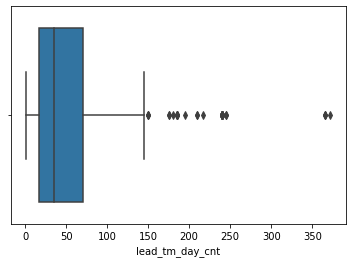

In [75]:
import seaborn as sns
sns.boxplot(x=df_training['lead_tm_day_cnt'])

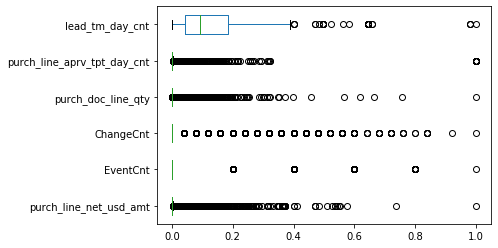

In [126]:
import pandas as pd
import matplotlib.pyplot as plt

#df_scaled[numeric_features.drop(['purch_line_net_usd_amt','purch_doc_line_qty'])].plot(kind='box')
df_scaled[numeric_features].plot(kind='box',vert=False)
plt.show()

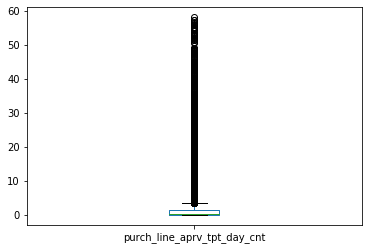

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

df_training['purch_line_aprv_tpt_day_cnt'].plot(kind='box')
plt.show()

In [21]:
numeric_features

Index(['LeadTime', 'purch_line_net_usd_amt', 'EventCnt', 'ChangeCnt',
       'SupplierDaysLate', 'purch_doc_line_qty',
       'purch_line_aprv_tpt_day_cnt'],
      dtype='object')

In [17]:
# code to remove outliers from numeric columns

df_cat = df_training.select_dtypes(include=['object'])
df_num = df_training[numeric_features]

from scipy import stats
idx = np.all(stats.zscore(df_num) < 3, axis=1)

df_training = pd.concat([df_num.loc[idx], df_cat.loc[idx]], axis=1)

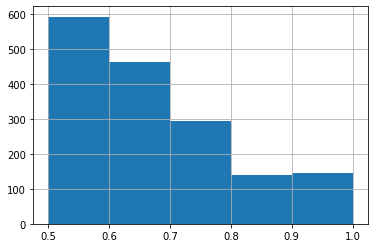

In [126]:
df_hist = df_predictions[(df_predictions['Prediction']=='Late') & (df_predictions.purch_line_rcv_sts_cd.str.strip().isin(['OPEN','PARTIAL']))]


hist = df_hist.Probability.hist(bins=5)

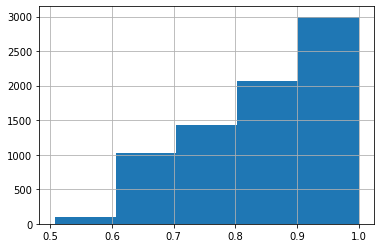

In [127]:
df_hist = df_predictions[(df_predictions['Prediction']=='OnTime') & (df_predictions.purch_line_rcv_sts_cd.str.strip().isin(['OPEN','PARTIAL']))]


hist = df_hist.Probability.hist(bins=5)

In [134]:
# saving the predictions of Random Forest as new target
new_target = rf.predict(X_train)

# defining the interpretable decision tree model
dt_model = DecisionTreeRegressor(max_depth=5, random_state=10)

# fitting the surrogate decision tree model using the training set and new target
dt_model.fit(X_train,new_target)

ValueError: could not convert string to float: 'G83731-XXX                         '

In [19]:
df_predictions.to_csv(r'C:\Users\jrstrong\Desktop\temp\AT_IDM_OTDPredictions_results.csv', index=False)